# Imports


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

%matplotlib inline

# Create Tiles

In [2]:
input_file_post = '../Datasets/Post_Event_San_Juan.tif'
input_file_pre = '../Datasets/Pre_Event_San_Juan.tif'
output_dir_post = "../Post_Event_Grids_In_TIFF"
output_dir_pre = "../Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512

In [ ]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [ ]:
generate_tiles(input_file_post, output_dir_post, grid_x, grid_y)
generate_tiles(input_file_pre, output_dir_pre, grid_x, grid_y)

# Convert tiles to jpg for labelling compatability

In [20]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            print(os.path.join(output_dir, output_filename))
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [3]:
output_dir_post_jpg = "../Post_Event_Grids_In_JPG"
output_dir_pre_jpg = "../Pre_Event_Grids_In_JPG"
input_dir_post = "../Post_Event_Grids_In_TIFF"
input_dir_pre = "../Pre_Event_Grids_In_TIFF"

# convert_tiff_to_jpeg(input_dir_post, output_dir_post_jpg)
# convert_tiff_to_jpeg(input_dir_pre, output_dir_pre_jpg)

In [3]:
def rename_files(directory_path, prefix):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [ ]:
rename_files(output_dir_post_jpg, "Post_Event_")
rename_files(output_dir_pre_jpg, "Pre_Event_")

# Coordinates

In [22]:
input_file_post = '../Datasets/Post_Event_San_Juan.tif'
input_file_pre = '../Datasets/Pre_Event_San_Juan.tif'
output_dir_post = "../Post_Event_Grids_In_TIFF"
output_dir_pre = "../Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512

In [23]:
def load_tiff_dimensions(image_path):
    with rasterio.open(image_path) as src:
        # Get the dimensions of the TIFF file
        img_width, img_height = src.width, src.height
        
        return img_width, img_height

# Replace 'image_path.tif' with the path to your GeoTIFF file
img_width, img_height = load_tiff_dimensions(input_file_post)
print(f"TIFF dimensions: {img_width} x {img_height}")


TIFF dimensions: 38259 x 74602


In [6]:
def convert_coordinates_to_tiff_space(x, y, geographic_coverage, tiff_dimensions):
    geographic_width, geographic_height = geographic_coverage
    tiff_width, tiff_height = tiff_dimensions
    
    # Calculate the scaling factors
    x_scale = tiff_width / geographic_width
    y_scale = tiff_height / geographic_height
    
    # Convert the coordinates to TIFF space
    tiff_x = int(x * x_scale)
    tiff_y = int(y * y_scale)
    
    return tiff_x, tiff_y


In [7]:
""""
6260.256050  6022.519245
4588.879052  3660.092141
4522.345390  5585.711295
6358.288740  3940.047788
"""


pre_storm_matplot_coords = [
    convert_coordinates_to_tiff_space(6022.519245 - 300, 6260.256050 - 300, (11477.699999999999, 22380.6), (38259, 74602)),
    convert_coordinates_to_tiff_space(3660.092141 - 300, 4588.879052 - 300, (11477.699999999999, 22380.6), (38259, 74602)),
    convert_coordinates_to_tiff_space(5585.711295 -  300, 4522.345390 - 300, (11477.699999999999, 22380.6), (38259, 74602)),
    convert_coordinates_to_tiff_space(3940.047788 - 300, 6358.288740 - 300, (11477.699999999999, 22380.6), (38259, 74602))
]
                 
print(pre_storm_matplot_coords)

[(19075, 19867), (11200, 14296), (17619, 14074), (12133, 20194)]


In [8]:
post_storm_matplot_coords = []

post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(10778 - 300, 6828 - 300, (11477.699999999999, 22380.6), (38259, 74602))) 
post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(10915 - 300, 7884 - 300, (11477.699999999999, 22380.6), (38259, 74602))) 
post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(9291 - 300, 7726 - 300, (11477.699999999999, 22380.6), (38259, 74602))) 
post_storm_matplot_coords.append(convert_coordinates_to_tiff_space(9455 - 300, 6835 - 300, (11477.699999999999, 22380.6), (38259, 74602)))

print(post_storm_matplot_coords)

[(34926, 21760), (35383, 25280), (29970, 24753), (30516, 21783)]


In [9]:
def coords_sorted(coords):
    # Sort the points by their y-coordinate (assuming y=0 is at the top of the image)
    top_two_points = sorted(coords, key=lambda x: x[1])[:2]
    bottom_two_points = sorted(coords, key=lambda x: x[1])[2:]

    # Within the top two points, sort by x to find the left and right
    top_left = min(top_two_points, key=lambda x: x[0])
    top_right = max(top_two_points, key=lambda x: x[0])

    # Do the same for the bottom two points
    bottom_left = min(bottom_two_points, key=lambda x: x[0])
    bottom_right = max(bottom_two_points, key=lambda x: x[0])

    # Now reorder the list
    return [top_left, top_right, bottom_right, bottom_left]

In [10]:
post_event_coords = coords_sorted(post_storm_matplot_coords) 
pre_event_coords = coords_sorted(pre_storm_matplot_coords)


# Show the Tiling

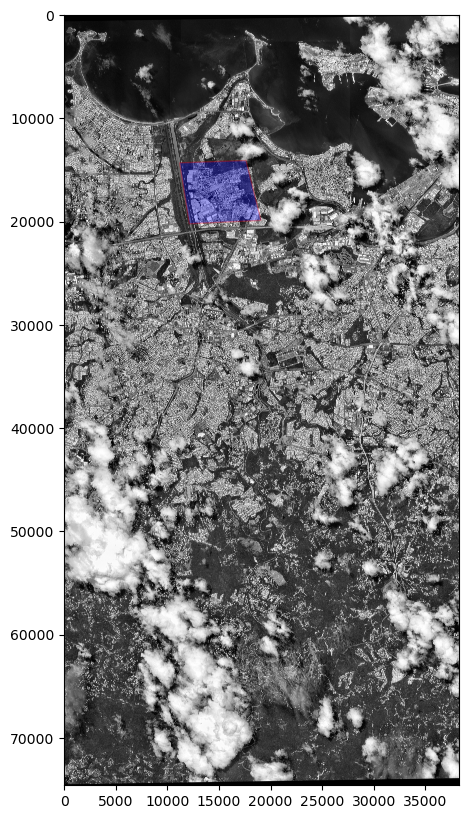

In [18]:
import rasterio
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon


# Load the pre-event image
with rasterio.open(input_file_pre) as src:
    pre_event_data = src.read(1)
    fig, ax1 = plt.subplots(figsize=(10, 10))

    # Draw a translucent polygon
    polygon = Polygon(pre_event_data, alpha=0.3, closed=True, facecolor='blue', edgecolor='r')
    ax1.add_patch(polygon)
    
    # Display the image
    ax1.imshow(pre_event_data, cmap='gray')
    plt.show()


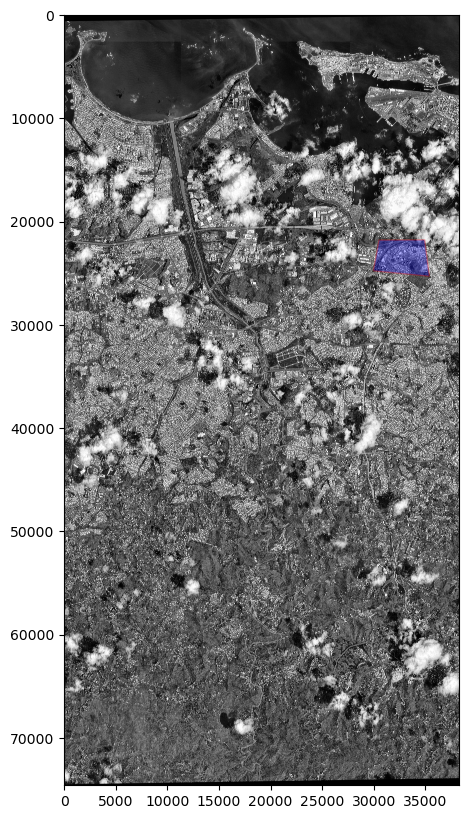

In [20]:
import rasterio
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Load the pre-event image
with rasterio.open(input_file_post) as src:
    pre_event_data = src.read(1)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    
    # Draw a translucent polygon
    polygon = Polygon(post_event_coords, alpha=0.3, closed=True, facecolor='blue', edgecolor='r')
    ax1.add_patch(polygon)

    # Display the image
    ax1.imshow(pre_event_data, cmap='gray')
    plt.show()


In [1]:
import gc

# Collect garbage
gc.collect()


10

# Save the New Tiling for Labelling

In [17]:
from osgeo import gdal, ogr
import os
import logging
logging.basicConfig(level=logging.DEBUG)

def generate_tiles(input_file, output_dir, grid_x, grid_y, polygon_coords):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Create a polygon from the reordered coordinates
    ring = ogr.Geometry(ogr.wkbLinearRing)
    for coord in polygon_coords:
        ring.AddPoint(coord[0], coord[1])
    polygon = ogr.Geometry(ogr.wkbPolygon)
    polygon.AddGeometry(ring)

    # Calculate the extent of the polygon
    minX, maxX, minY, maxY = polygon.GetEnvelope()

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i * grid_x
            y_offset = j * grid_y

            # Check if the current tile is within the extent of the polygon
            if x_offset > maxX or x_offset + grid_x < minX or y_offset > maxY or y_offset + grid_y < minY:
                continue  # Skip tiles outside the polygon extent

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)
            


            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)
                print(f"Band {band} shape: {tile_data.shape}")

            # Create output filename
            
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
            print(f"Output file: {output_file}")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)

            # Set the geotransform and projection as in the input
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))
            out_ds.SetProjection(ds.GetProjection())

            try:
                # Write each band to the output file
                for band in range(1, num_bands + 1):
                    out_band = out_ds.GetRasterBand(band)
                    out_band.WriteArray(tile[band - 1])
                    out_band.FlushCache()  # Ensure data is written to disk
            except Exception as e:
                logging.error(f"Failed to write tile {i}_{j}: {e}")

            # Make sure to close the dataset to flush to disk
            if out_ds is not None:
                out_ds.FlushCache()  # Ensure data is written to disk
                out_ds = None

    print("Tiles generation completed within the polygon area.")




In [18]:
input_file_post = '../Datasets/Post_Event_San_Juan.tif'
input_file_pre = '../Datasets/Pre_Event_San_Juan.tif'
output_dir_post = "../Post_Event_Grids_In_TIFF"
output_dir_pre = "../Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
tile_labelling_output_dir_post = "../Post_Event_Grids_In_TIFF_Kacper_Selections"
tile_labelling_output_dir_pre = "../Pre_Event_Grids_In_TIFF_Kacper_Selections"


# Call the function with the reordered coordinates
generate_tiles(input_file_post, tile_labelling_output_dir_post, grid_x, grid_y, post_event_coords)
generate_tiles(input_file_pre, tile_labelling_output_dir_pre, grid_x, grid_y, pre_event_coords)

Total number of tiles: 10730
Band 1 shape: (512, 512)
Band 2 shape: (512, 512)
Band 3 shape: (512, 512)
Output file: ../Post_Event_Grids_In_TIFF_Kacper_Selections\tile_58_42.tif
Band 1 shape: (512, 512)
Band 2 shape: (512, 512)
Band 3 shape: (512, 512)
Output file: ../Post_Event_Grids_In_TIFF_Kacper_Selections\tile_58_43.tif
Band 1 shape: (512, 512)
Band 2 shape: (512, 512)
Band 3 shape: (512, 512)
Output file: ../Post_Event_Grids_In_TIFF_Kacper_Selections\tile_58_44.tif
Band 1 shape: (512, 512)
Band 2 shape: (512, 512)
Band 3 shape: (512, 512)
Output file: ../Post_Event_Grids_In_TIFF_Kacper_Selections\tile_58_45.tif
Band 1 shape: (512, 512)
Band 2 shape: (512, 512)
Band 3 shape: (512, 512)
Output file: ../Post_Event_Grids_In_TIFF_Kacper_Selections\tile_58_46.tif
Band 1 shape: (512, 512)
Band 2 shape: (512, 512)
Band 3 shape: (512, 512)
Output file: ../Post_Event_Grids_In_TIFF_Kacper_Selections\tile_58_47.tif
Band 1 shape: (512, 512)
Band 2 shape: (512, 512)
Band 3 shape: (512, 512)
Ou

In [21]:
tile_labelling_output_dir_post_jpg = "../Post_Event_Grids_In_JPG_Kacper_Selections"
tile_labelling_output_dir_pre_jpg = "../Pre_Event_Grids_In_JPG_Kacper_Selections"

convert_tiff_to_jpeg(tile_labelling_output_dir_post, tile_labelling_output_dir_post_jpg)
convert_tiff_to_jpeg(tile_labelling_output_dir_pre, tile_labelling_output_dir_pre_jpg)

DEBUG:PIL.Image:Importing BlpImagePlugin
DEBUG:PIL.Image:Importing BmpImagePlugin
DEBUG:PIL.Image:Importing BufrStubImagePlugin
DEBUG:PIL.Image:Importing CurImagePlugin
DEBUG:PIL.Image:Importing DcxImagePlugin
DEBUG:PIL.Image:Importing DdsImagePlugin
DEBUG:PIL.Image:Importing EpsImagePlugin
DEBUG:PIL.Image:Importing FitsImagePlugin
DEBUG:PIL.Image:Importing FliImagePlugin
DEBUG:PIL.Image:Importing FpxImagePlugin
DEBUG:PIL.Image:Image: failed to import FpxImagePlugin: No module named 'olefile'
DEBUG:PIL.Image:Importing FtexImagePlugin
DEBUG:PIL.Image:Importing GbrImagePlugin
DEBUG:PIL.Image:Importing GifImagePlugin
DEBUG:PIL.Image:Importing GribStubImagePlugin
DEBUG:PIL.Image:Importing Hdf5StubImagePlugin
DEBUG:PIL.Image:Importing IcnsImagePlugin
DEBUG:PIL.Image:Importing IcoImagePlugin
DEBUG:PIL.Image:Importing ImImagePlugin
DEBUG:PIL.Image:Importing ImtImagePlugin
DEBUG:PIL.Image:Importing IptcImagePlugin
DEBUG:PIL.Image:Importing JpegImagePlugin
DEBUG:PIL.Image:Importing Jpeg2KImageP

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_46.jpg


DEBUG:PIL.TiffImagePlugin:*** TiffImageFile._open ***
DEBUG:PIL.TiffImagePlugin:- __first: 8
DEBUG:PIL.TiffImagePlugin:- ifh: b'II*\x00\x08\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:Seeking to frame 0, on frame -1, __next 8, location: 8
DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffIma

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_58_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_42.jpg


DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpr

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_47.jpg


DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** Summary ***
DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- pla

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_59_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_44.jpg


DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_60_49.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_47.jpg


DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xe2b\n\x00\xc3d\x0c\x00\xc1s\x0e\x00\xc3\x7f\x10\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'\xe1\x01\x02\x00\xfe\x0e\x02\x00\x02\x0c\x02\x00\xc3&\x02\x00'
DEBUG:PIL.

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_61_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_45.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xaa\xce\t\x00c

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_62_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_43.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'3x\t\x00Lv\x0b\

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_48.jpg


DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** Summary ***
DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Locat

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_63_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_45.jpg


DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'X`\n\x00\xd5_\x0c\x00\xa3u\x0e\x00\x1e\x87\x10\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'}\xff\x01\x00\xce\x15\x02\x00{\x11\x02\x00\xcb \x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type:

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_64_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_42.jpg


DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xef\x8d\t\x00\x84w\x0b\x00\xbeo\r\x00\xdeD\x0f\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'\x95\xe9\x01\x00:\xf8\x01\x00 \xd5\x01\x00\x07\xe8\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - t

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_47.jpg


DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** Summary ***
DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- s

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_65_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_44.jpg


DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** Summary ***
DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugi

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_66_49.jpg


DEBUG:PIL.TiffImagePlugin:- ifh: b'II*\x00\x08\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:Seeking to frame 0, on frame -1, __next 8, location: 8
DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugi

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_46.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'!\xdb\t\x00\xfb

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_67_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_43.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_46.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_48.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'\x85\xff\x01\x00\xee\xe0\x01\x00\xa3\x0e\x02\x00\xc6\xf9\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_68_49.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_42.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_43.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_44.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_45.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_46.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b"N[\n\x00ct\x0c\

../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_47.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_48.jpg
../Post_Event_Grids_In_JPG_Kacper_Selections\tile_69_49.jpg
Conversion from TIFF to JPEG completed.
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_29.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'ZF\x07\x00\x89\

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_34.jpg


DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_21_39.jpg


DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:P

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_32.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xed\xcd\x07\x0

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_38.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\x8c.\x08\x00\xa7\xdf\t\x005\x82\x0b\x00\xd1\x1f\r\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'\x1b\xb1\x01\x00\x8e\xa2\x01\x00\x9c\x9d\x01\x00\x17\xa0\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag 

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_22_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_30.jpg


DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpr

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_35.jpg


DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpr

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_23_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_27.jpg


DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b"(G\x08\x00&\xd8\t\x00'\x95\x0b\x00\x074\r\x00"
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - ty

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_32.jpg


DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'M\xdc\x07\x00yI\t\x00\xb8\xcc\n\x00\x11m\x0c\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b',m\x01\x00?\x83\x01\x00Y\xa0\x01\x00@\xab\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepo

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_37.jpg


DEBUG:PIL.TiffImagePlugin:- ifh: b'II*\x00\x08\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:Seeking to frame 0, on frame -1, __next 8, location: 8
DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugi

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_24_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_29.jpg


DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** TiffImageFile._open ***
DEBUG:PIL.TiffImagePlugin:- __first: 8
DEBUG:PIL.TiffImagePlugin:- ifh: b'II*\x00\x08\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:Seeking to f

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_33.jpg


DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b"dO\t\x00A>\x0b\x00\x91'\r\x00\xbe\xee\x0e\x00"
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - ty

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_38.jpg


DEBUG:PIL.TiffImagePlugin:*** TiffImageFile._open ***
DEBUG:PIL.TiffImagePlugin:- __first: 8
DEBUG:PIL.TiffImagePlugin:- ifh: b'II*\x00\x08\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:Seeking to frame 0, on frame -1, __next 8, location: 8
DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffIma

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_25_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_30.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'|\xea\x01\x00\xfe\xf3\x01\x00\xa4\xf6\x01\x00*\xef\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.Ti

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_36.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'Y>\x08\x00\x00\

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_26_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_29.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_34.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'D\x80\x01\x00\xe0\xf2\x01\x00{\x9f\x01\x00\xaa\x92\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.Ti

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_27_39.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'i\x9b\x01\x00\xad\x86\x01\x00\xd7w\x01\x005\x95\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffI

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_31.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_36.jpg


DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_28_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_28.jpg


DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xe9\x87\x07\x00\x85\x14\t\x00\xa2r\n\x00\x88\xfd\x0b\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCount

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_33.jpg


DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpr

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_29_39.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'Gn\t\x00\xa6.\x0b\x00\xe9\x0c\r\x00\xb8\x04\x0f\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'_\xc0\x01\x00C\xde\x01\x00\xcf\xf7\x01\x00\xba\xf2\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_32.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_37.jpg


DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** Summary ***
DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugi

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_30_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_30.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xcf\x01\t\x00\

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_35.jpg


DEBUG:PIL.TiffImagePlugin:- ifh: b'II*\x00\x08\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:Seeking to frame 0, on frame -1, __next 8, location: 8
DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugi

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_31_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_27.jpg


DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** Summary ***
DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- pla

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_32.jpg


DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlug

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_37.jpg


DEBUG:PIL.TiffImagePlugin:*** Summary ***
DEBUG:PIL.TiffImagePlugin:- compression: tiff_adobe_deflate
DEBUG:PIL.TiffImagePlugin:- photometric_interpretation: 2
DEBUG:PIL.TiffImagePlugin:- planar_configuration: 1
DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:P

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_32_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_29.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'Y+\x08\x00\xb2\xf6\t\x00\xfe\x8a\x0b\x00\x04D\r\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'Y\xcb\x01\x00L\x94\x01\x00\x06\xb9\x01\x00\x10i\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - ty

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_34.jpg


DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - v

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_33_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_27.jpg


DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:*** TiffImageFile._open ***
DEBUG:PIL.TiffImagePlugin:- __first: 8
DEBUG:PIL.TiffImagePlugin:- ifh: b'II*\x00\x08\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:Seeking to frame 0, on frame -1, __next 8, location: 8
DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data L

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_29.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_32.jpg


DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xdel\x06\x00\xe8\xc4\x07\x00\xaa\x01\t\x00\xb9H\n\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'\nX\x01\x00\xc2<\x01\x00\x0fG\x01\x00\xf56\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_37.jpg


DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'K[\x08\x00\xb1A\n\x00c\x86\x0b\x00\xdac\r\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - ty

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_34_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_29.jpg


DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\xfd_\x08\x00;+

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_33.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'\x00\x99\x07\x00D%\t\x00)\xb1\n\x00:=\x0c\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'D\x8c\x01\x00\xe5\x8b\x01\x00\x11\x8c\x01\x00fi\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.Tif

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_37.jpg


DEBUG:PIL.TiffImagePlugin:- fill_order: 1
DEBUG:PIL.TiffImagePlugin:- YCbCr subsampling: None
DEBUG:PIL.TiffImagePlugin:- size: (512, 512)
DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_38.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_35_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_29.jpg


DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b'7\x10\x07\x00\xecd\x08\x00\xf2\xd9\t\x00\xaa>\x0b\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (3

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_33.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_34.jpg


DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - type: short (3) Tag Location: 202 - Data Location: 334 - value: <table: 64 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoAsciiParamsTag (34737) - type: string (2) Tag Location: 214 - Data Location: 398 - value: b'WGS 84 / UTM zone 19N|WGS 84|\x00'
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_38.jpg


DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.T

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_36_39.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_27.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_28.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_29.jpg


DEBUG:PIL.TiffImagePlugin:tag: TileLength (323) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: TileOffsets (324) - type: long (4) Tag Location: 142 - Data Location: 240 - value: b"_\xab\x07\x00\xc1'\t\x00\x8c\xb7\n\x00\xe29\x0c\x00"
DEBUG:PIL.TiffImagePlugin:tag: TileByteCounts (325) - type: long (4) Tag Location: 154 - Data Location: 224 - value: b'b|\x01\x00\xcb\x8f\x01\x00V\x82\x01\x00\xcb\x8e\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: SampleFormat (339) - type: short (3) Tag Location: 166 - Data Location: 256 - value: b'\x01\x00\x01\x00\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelPixelScaleTag (33550) - type: double (12) Tag Location: 178 - Data Location: 262 - value: b'\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x88\xd3?\x00\x00\x00\x00\x00\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ModelTiepointTag (33922) - type: double (12) Tag Location: 190 - Data Location: 286 - value: <table: 48 bytes>
DEBUG:PIL.TiffImagePlugin:tag: GeoKeyDirectoryTag (34735) - ty

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_30.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_31.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_32.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_33.jpg


DEBUG:PIL.TiffImagePlugin:format key: (b'II', 2, (1,), 1, (8, 8, 8), ())
DEBUG:PIL.TiffImagePlugin:- raw mode: RGB
DEBUG:PIL.TiffImagePlugin:- pil mode: RGB
DEBUG:PIL.TiffImagePlugin:have fileno, calling fileno version of the decoder.
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - v

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_34.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_35.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_36.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_37.jpg
../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_38.jpg


DEBUG:PIL.TiffImagePlugin:Seeking to frame 0, on frame -1, __next 8, location: 8
DEBUG:PIL.TiffImagePlugin:Loading tags, location: 8
DEBUG:PIL.TiffImagePlugin:tag: ImageWidth (256) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: ImageLength (257) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: BitsPerSample (258) - type: short (3) Tag Location: 46 - Data Location: 218 - value: b'\x08\x00\x08\x00\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: Compression (259) - type: short (3) - value: b'\x08\x00'
DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: SamplesPerPixel (277) - type: short (3) - value: b'\x03\x00'
DEBUG:PIL.TiffImagePlugin:tag: PlanarConfiguration (284) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: Predictor (317) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: TileWidth (322) - type: short (3) - value: b'\x00\x01

../Pre_Event_Grids_In_JPG_Kacper_Selections\tile_37_39.jpg
Conversion from TIFF to JPEG completed.
